# 1. Import libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import gc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import root_mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from lightgbm import LGBMRegressor, Dataset
from catboost import Pool, CatBoostRegressor
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer, FunctionTransformer
from sklearn.model_selection import cross_val_score, KFold
import optuna
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingRegressor
from sklearn.compose import TransformedTargetRegressor
import warnings
warnings.filterwarnings("ignore")

# 2. Load data

## 2.1 Load train/data datasets

Original data was downloaded from [here](https://archive.ics.uci.edu/dataset/1/abalone)

In [58]:
# Import abalone data from Kaggle
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

# Import original data
original_names = pd.read_csv('data/abalone.names', names=['names'])
original = pd.read_csv('data/abalone.data', names=original_names['names'])

# Copy train and test datasets
train_copy = train.copy()
test_copy = test.copy()

# Tag original dataset
original["original"] = 1
train["original"] = 0
test["original"] = 0

# Drop 'id' columns
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

# Rename train and test column names to match names of the original dataset
train = train.rename(columns={'Whole weight':'Whole_weight','Whole weight.1':'Shucked_weight', 'Whole weight.2':'Viscera_weight', 'Shell weight':'Shell_weight'})
test = test.rename(columns={'Whole weight':'Whole_weight','Whole weight.1':'Shucked_weight', 'Whole weight.2':'Viscera_weight', 'Shell weight':'Shell_weight'})

# Concatenate train and original datasets
train = pd.concat([train, original], axis='rows')
train.reset_index(inplace=True, drop=True)

# Set device
device='gpu'

# Set target
target='Rings'

train.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,original
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,0
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,0
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,0
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,0
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,0


## 2.2 Check for missing values

In [4]:
table = PrettyTable()

table.field_names = ['Column Name', 'Data Type', 'Train Missing %', 'Test Missing %']
for column in train.columns:
    data_type = str(train[column].dtype)
    non_null_count_train = 100-train[column].count()/train.shape[0]*100
    if column != target:
        non_null_count_test = 100-test[column].count()/test.shape[0]*100
    else:
        non_null_count_test = "NA"
    table.add_row([column, data_type, non_null_count_train,non_null_count_test])
print(table)

+----------------+-----------+-----------------+----------------+
|  Column Name   | Data Type | Train Missing % | Test Missing % |
+----------------+-----------+-----------------+----------------+
|      Sex       |   object  |       0.0       |      0.0       |
|     Length     |  float64  |       0.0       |      0.0       |
|    Diameter    |  float64  |       0.0       |      0.0       |
|     Height     |  float64  |       0.0       |      0.0       |
|  Whole_weight  |  float64  |       0.0       |      0.0       |
| Shucked_weight |  float64  |       0.0       |      0.0       |
| Viscera_weight |  float64  |       0.0       |      0.0       |
|  Shell_weight  |  float64  |       0.0       |      0.0       |
|     Rings      |   int64   |       0.0       |       NA       |
|    original    |   int64   |       0.0       |      0.0       |
+----------------+-----------+-----------------+----------------+


# 3. Exploratory data analysis

# 3.1 Target analysis

In [4]:
def histogram_density(class_0, class_1, title):
    # Calculate mean and median of targets
    mean_0 = np.mean(class_0)
    mean_1 = np.mean(class_1)
    median_0 = np.median(class_0)
    median_1 = np.median(class_1)

    # Draw histogram and density plots
    fig, ax = plt.subplots(figsize=(12, 6))

    # Create histograms
    ax.hist(class_0, bins=20, density=True, alpha=0.5, label='Original=0 Histogram')
    ax.hist(class_1, bins=20, density=True, alpha=0.5, label='Original=1 Histogram')

    # Get x-axis values for density plot (class 0 and class 1)
    x_values_0 = np.linspace(class_0.min(), class_0.max(), len(class_0))
    x_values_1 = np.linspace(class_1.min(), class_1.max(), len(class_0))

    # Get density values of class 0 and class 1
    density_values_0 = (1 / (np.sqrt(2 * np.pi) * np.std(class_0))) * np.exp(-0.5 * ((x_values_0 - mean_0) / np.std(class_0))**2)
    density_values_1 = (1 / (np.sqrt(2 * np.pi) * np.std(class_1))) * np.exp(-0.5 * ((x_values_1 - mean_1) / np.std(class_1))**2)

    # Draw density plots
    ax.plot(x_values_0, density_values_0, color='red', label='Original=0 Density')
    ax.plot(x_values_1, density_values_1, color='green', label='Original=1 Density')

    # Draw mean plots
    ax.axvline(mean_0, color='blue', linestyle='dashed', linewidth=2, label='Mean (Original=0)')
    ax.axvline(mean_1, color='blue', linestyle='dashed', linewidth=2, label='Mean (Original=1)')

    # Draw median plots
    ax.axvline(median_0, color='green', linestyle='dashed', linewidth=2, label='Median (Original=0)')
    ax.axvline(median_1, color='red', linestyle='dashed', linewidth=2, label='Median (Original=1)')

    # Set labels and a title
    ax.set_xlabel(target)
    ax.set_ylabel('Frequency / Density')
    ax.set_title(title)

    # Set x-axis view limits
    x_min = min(min(class_0), min(class_1))
    x_max = max(max(class_0), max(class_1))
    ax.set_xlim([x_min, x_max])

    # Create a legend
    ax.legend(bbox_to_anchor=(1,1),fancybox=False,shadow=False, loc='upper left')

    # Show plot
    plt.tight_layout()
    plt.show()

### 3.1.1 Histogram and density plots

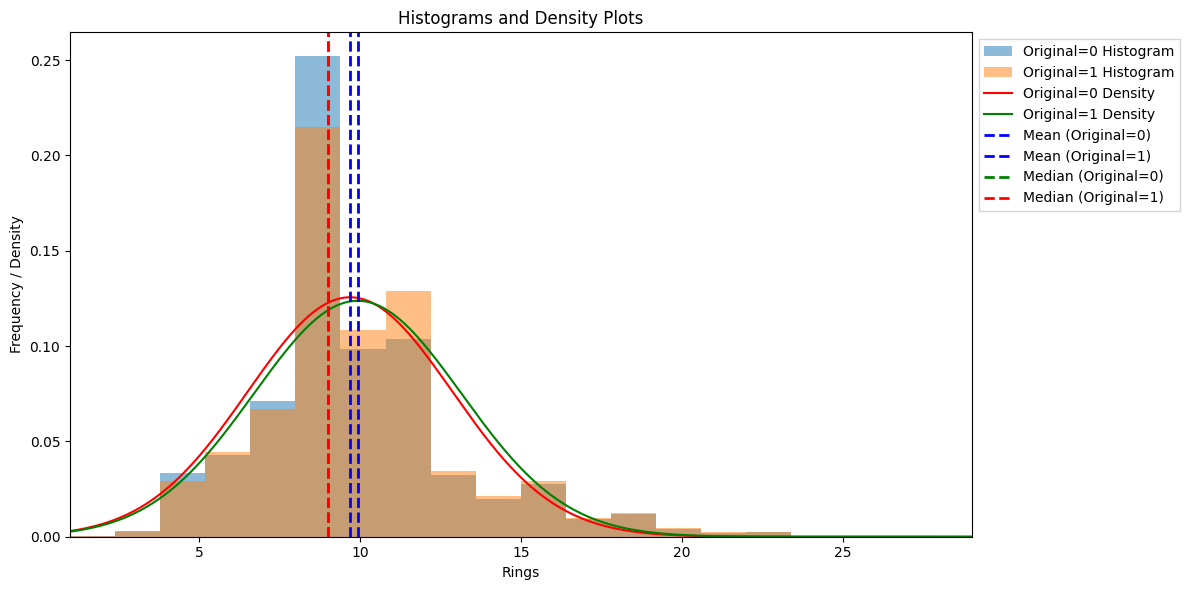

In [5]:
# Get target columns for train and original datasets
class_0 = train[train['original'] == 0][target]
class_1 = train[train['original'] == 1][target]

# Draw plot
histogram_density(class_0, class_1, 'Histograms and Density Plots')

### 3.1.2 Log transformed histogram and density plots

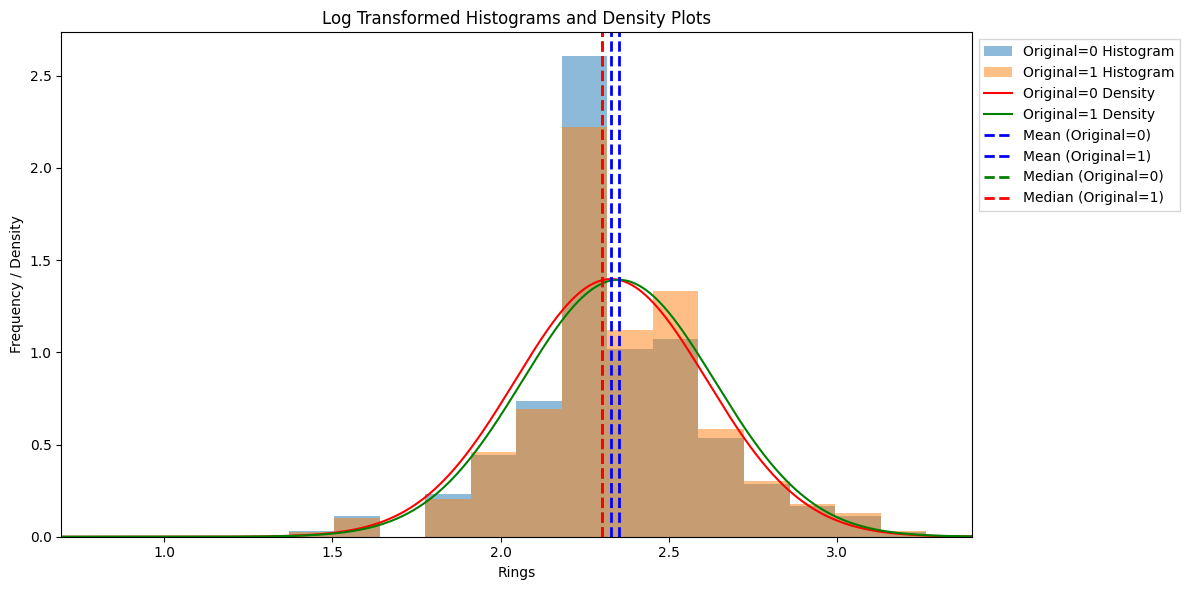

In [6]:
# Get log transformed target columns for train and original datasets
class_0 = np.log1p(train[train['original'] == 0][target])
class_1 = np.log1p(train[train['original'] == 1][target])

# Draw plot
histogram_density(class_0, class_1, 'Log Transformed Histograms and Density Plots')

## 3.2 Train & test data distributions

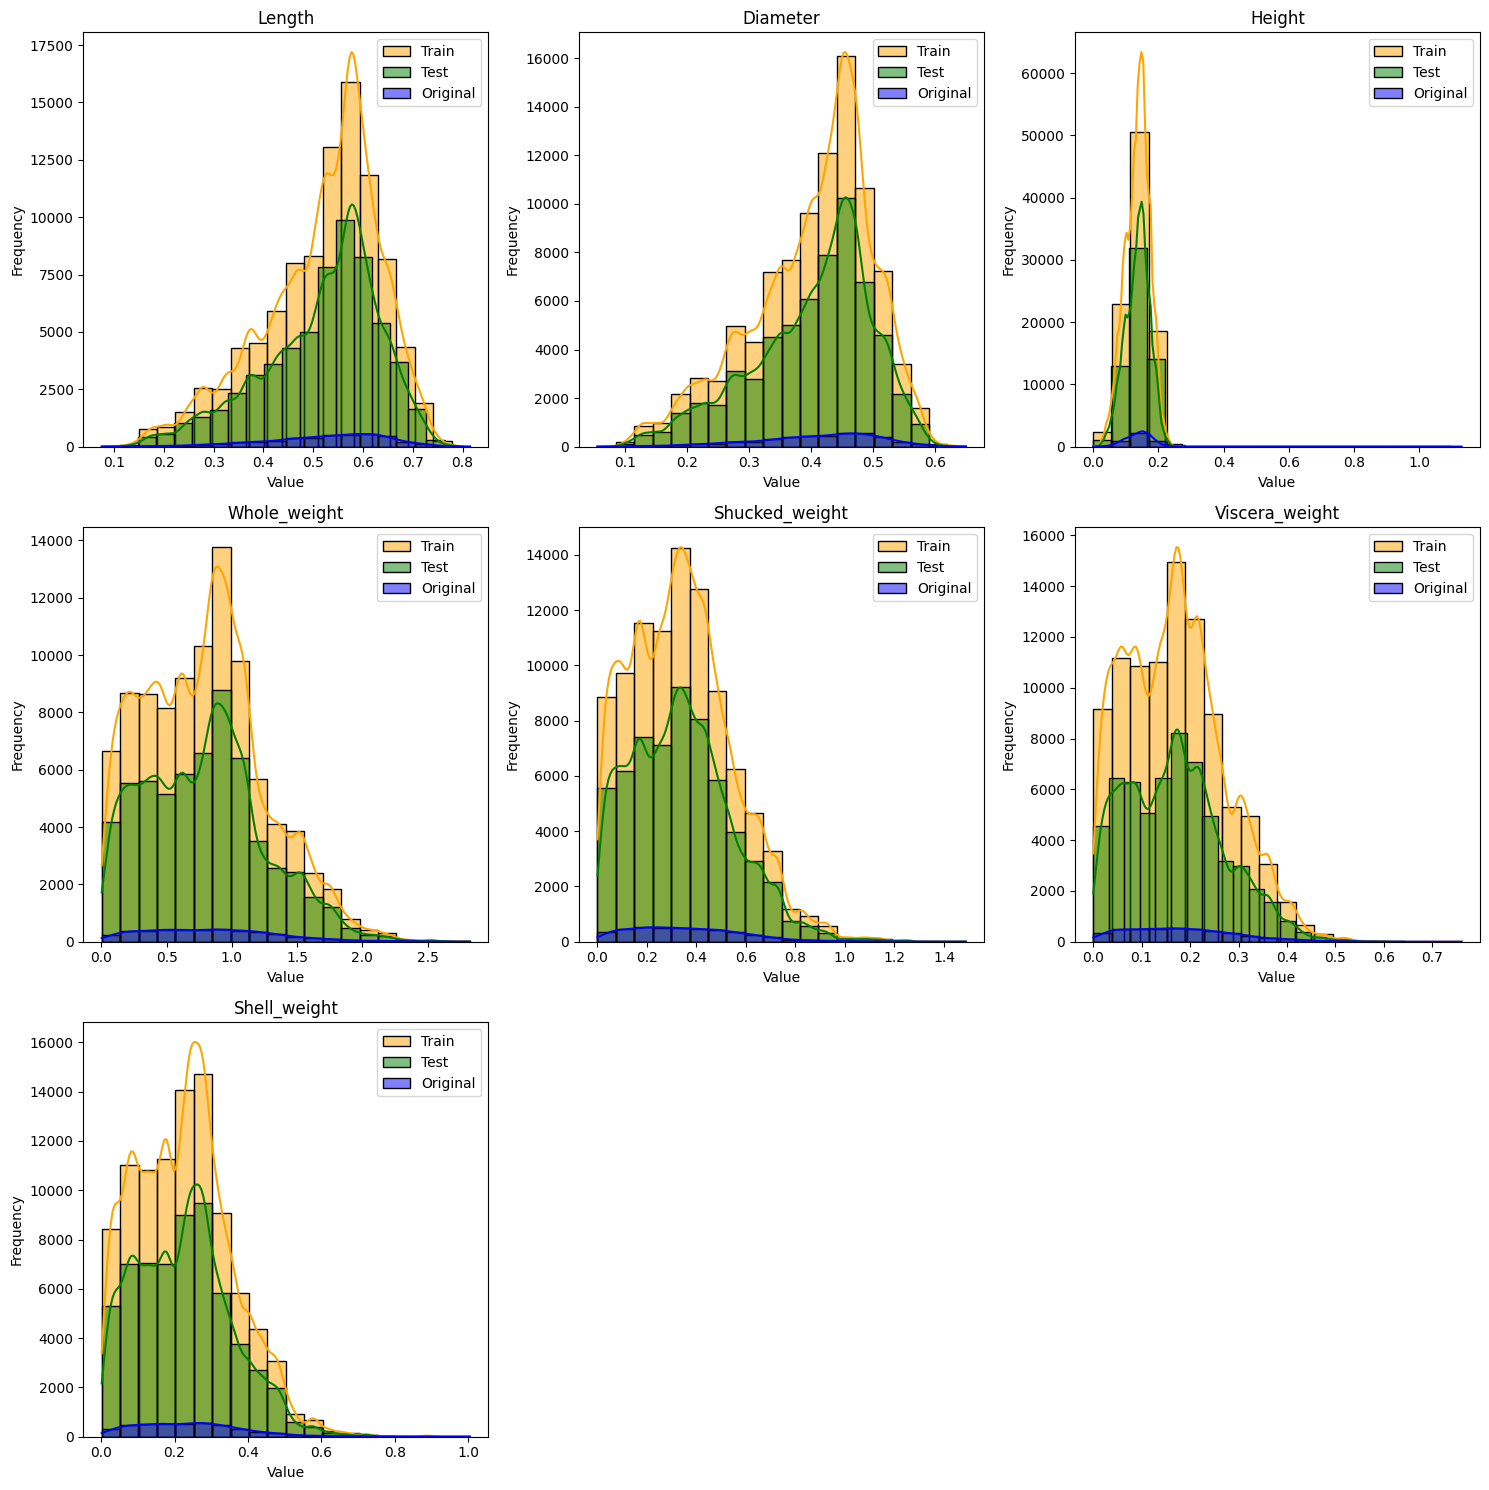

In [7]:
# Plot only numeric parameters with more than 2 unique elements (exclude target column)
cont_cols=[f for f in train.columns if train[f].dtype in [float,int] and train[f].nunique() > 2 and f not in [target]]

# Calculate number of rows needed for the subplots
num_rows = len(cont_cols)
while num_rows % 3 != 0: num_rows += 1
num_rows //= 3

# Create subplots for each continuous column
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Loop through each continuous column and plot the histograms
for i, col in enumerate(cont_cols):
    # Determine range of values to plot
    max_val = max(train[col].max(), test[col].max(), original[col].max())
    min_val = min(train[col].min(), test[col].min(), original[col].min())
    range_val = max_val - min_val

    # Determine the bin size and number of bins
    bin_size = range_val / 20
    num_bins_train = round(range_val / bin_size)
    num_bins_test = round(range_val / bin_size)
    num_bins_original = round(range_val / bin_size)

    # Calculate the subplot position
    row = i // 3
    col_pos = i % 3

    # Plot the histograms
    sns.histplot(train[col], ax=axs[row][col_pos], color='orange', kde=True, label='Train', bins=num_bins_train)
    sns.histplot(test[col], ax=axs[row][col_pos], color='green', kde=True, label='Test', bins=num_bins_test)
    sns.histplot(original[col], ax=axs[row][col_pos], color='blue', kde=True, label='Original', bins=num_bins_original)
    axs[row][col_pos].set_title(col)
    axs[row][col_pos].set_xlabel('Value')
    axs[row][col_pos].set_ylabel('Frequency')
    axs[row][col_pos].legend()

# Remove any empty subplots
if len(cont_cols) % 3 != 0:
    for col_pos in range(len(cont_cols) %3, 3):
        axs[-1][col_pos].remove()

# Show the plot
plt.tight_layout()
plt.show()

## 3.3 Sex & Numerical features

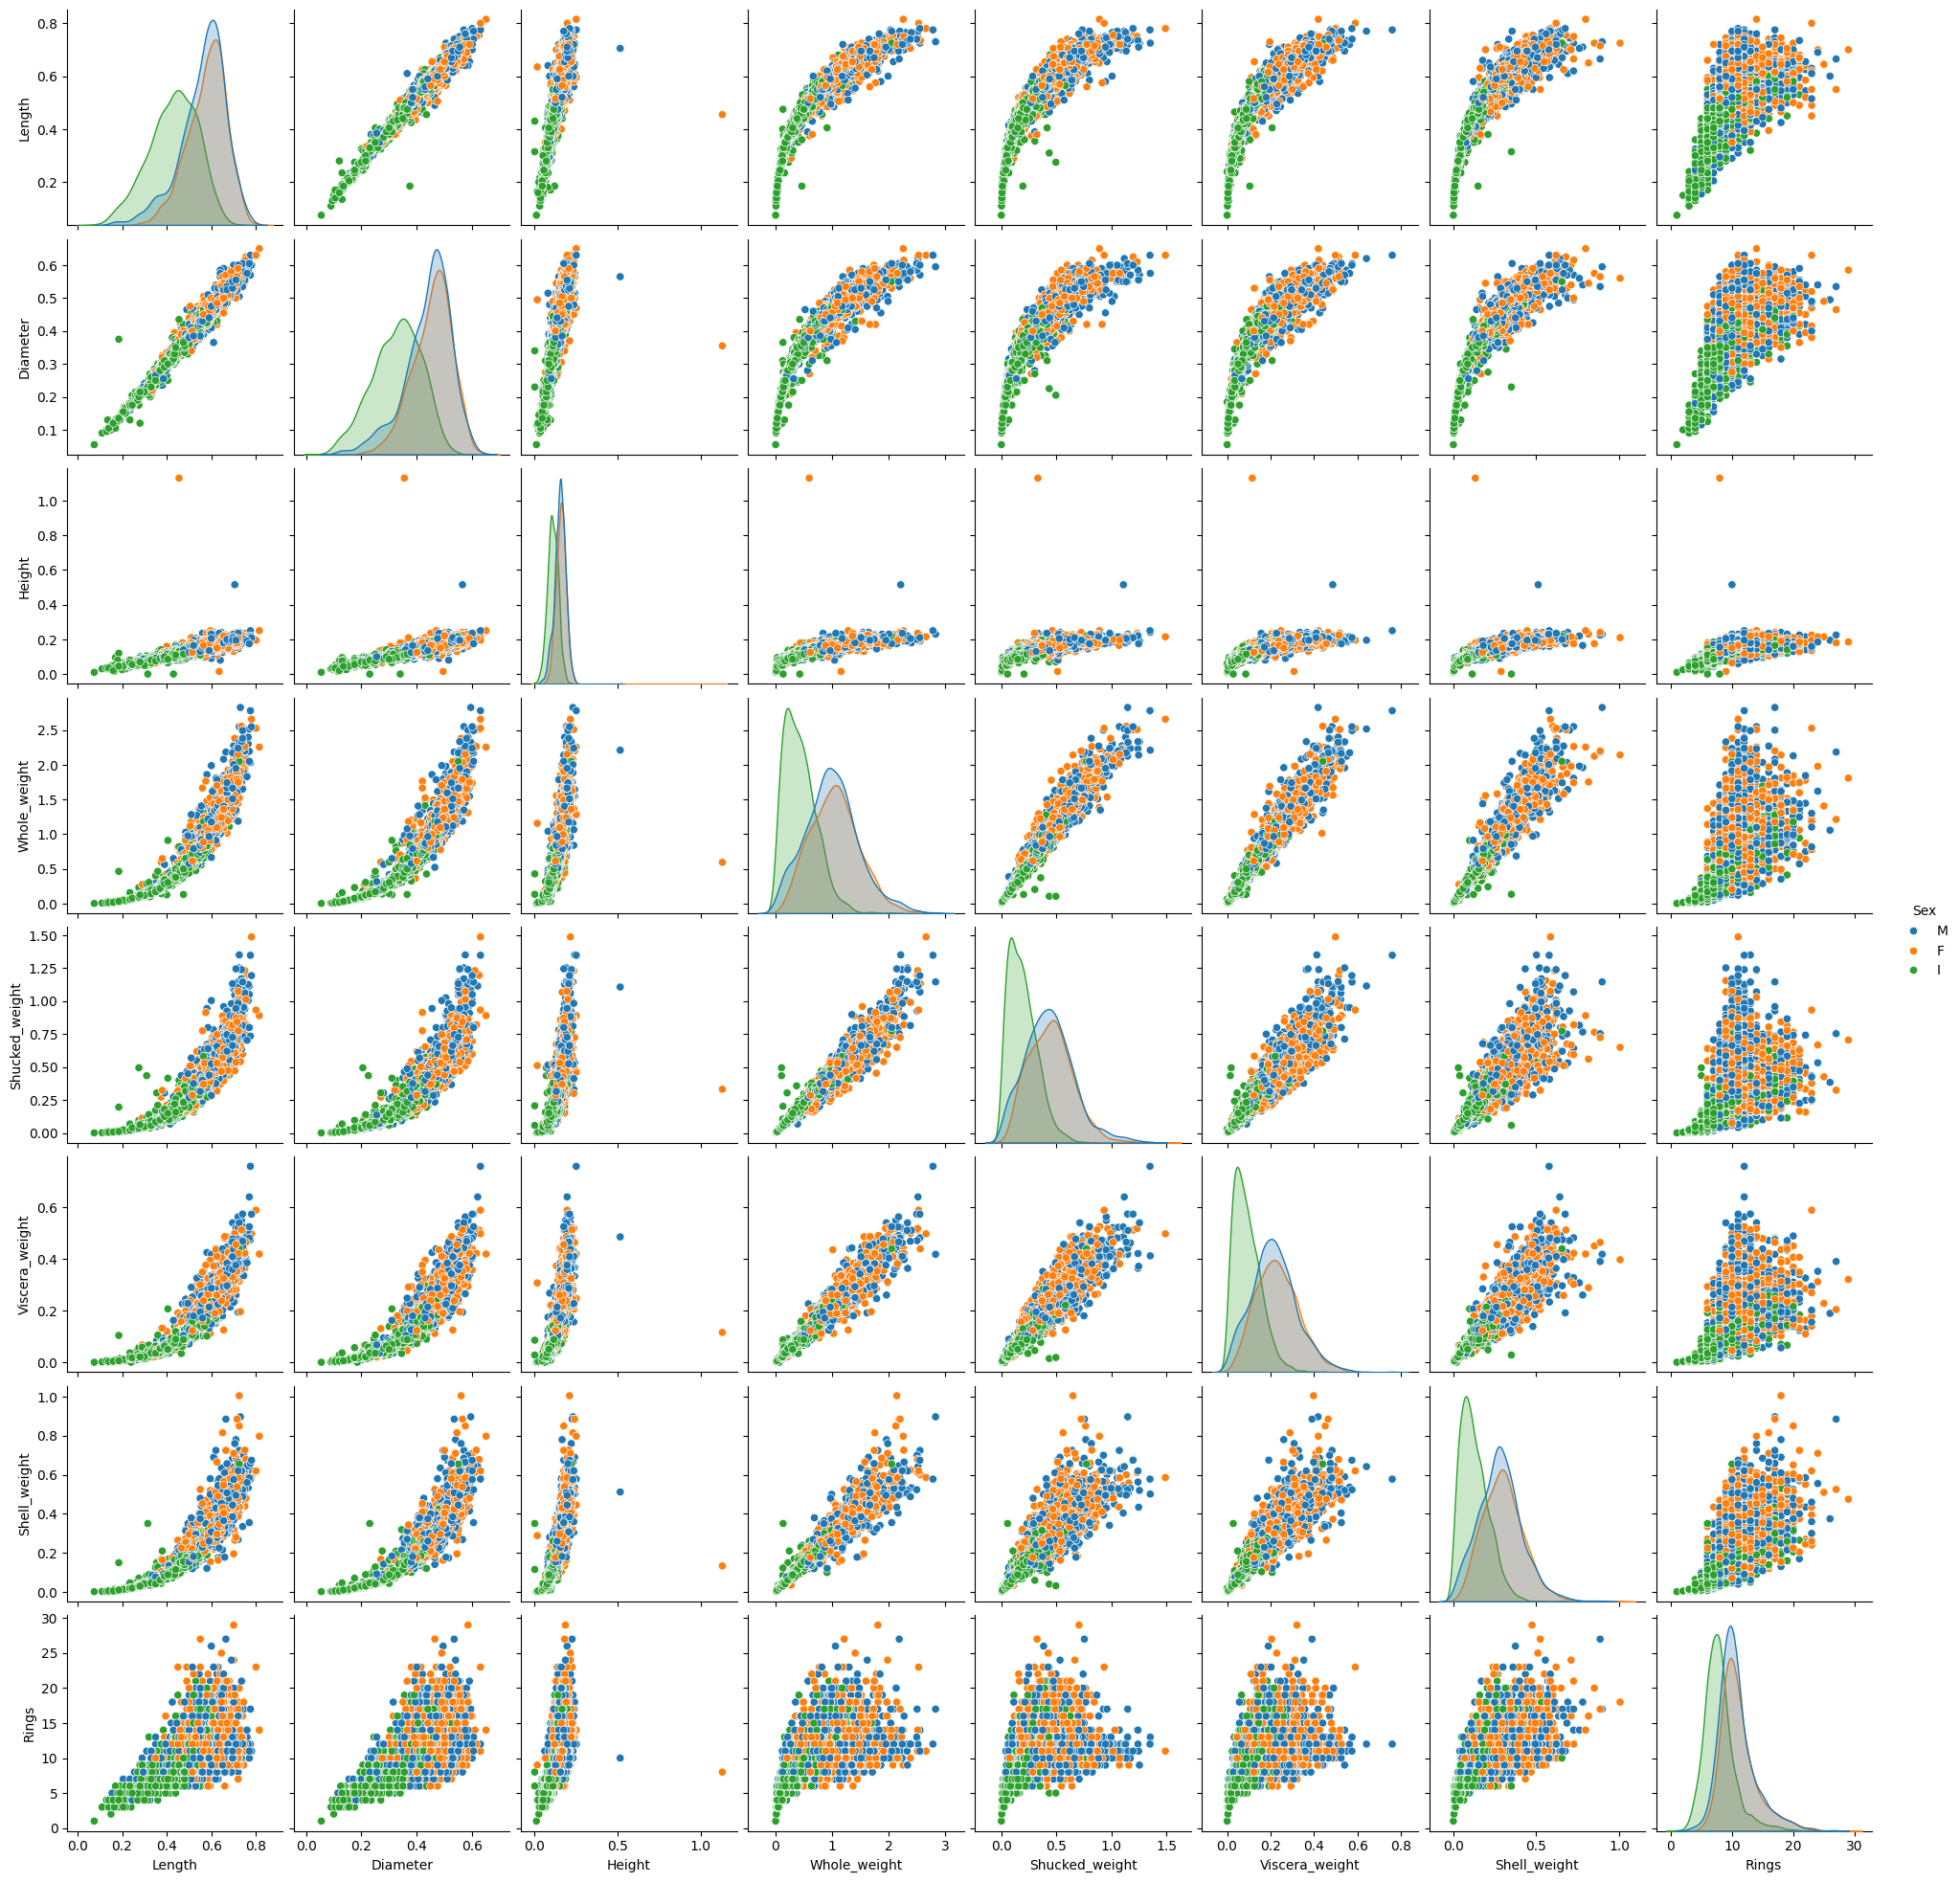

In [8]:
sns.pairplot(data=original, vars=cont_cols+[target], hue='Sex')
plt.show()

## 3.4 Rings vs Sex

/tmp/ipykernel_514695/2036932857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x = 'Sex', y = col, data = train, palette = 'pastel')


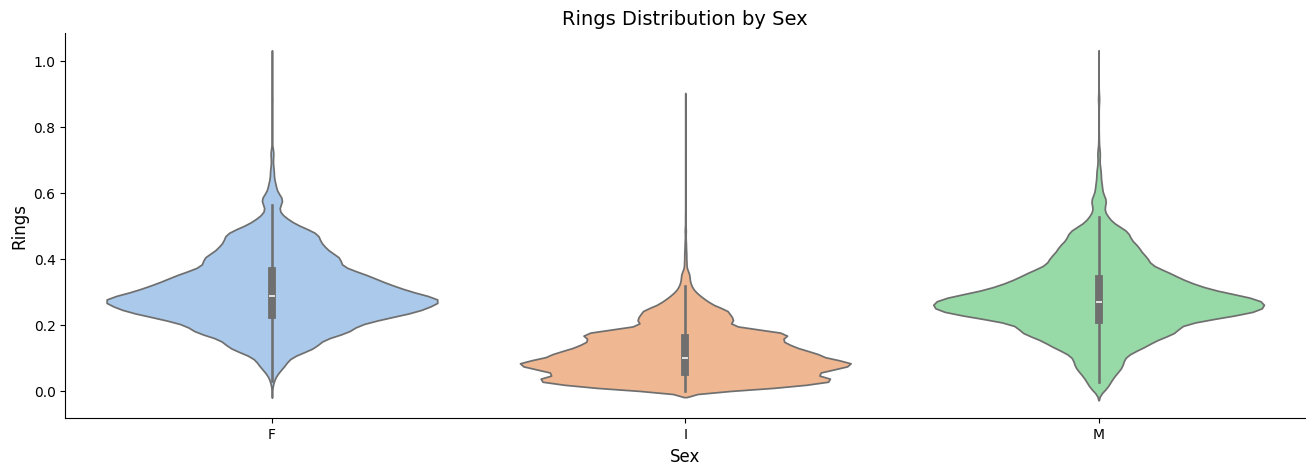

In [9]:
plt.subplots(figsize=(16, 5))
sns.violinplot(x = 'Sex', y = col, data = train, palette = 'pastel')
plt.title('Rings Distribution by Sex', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Rings', fontsize=12)
sns.despine()
fig.tight_layout()
plt.show()

## 3.5. Correlation matrix

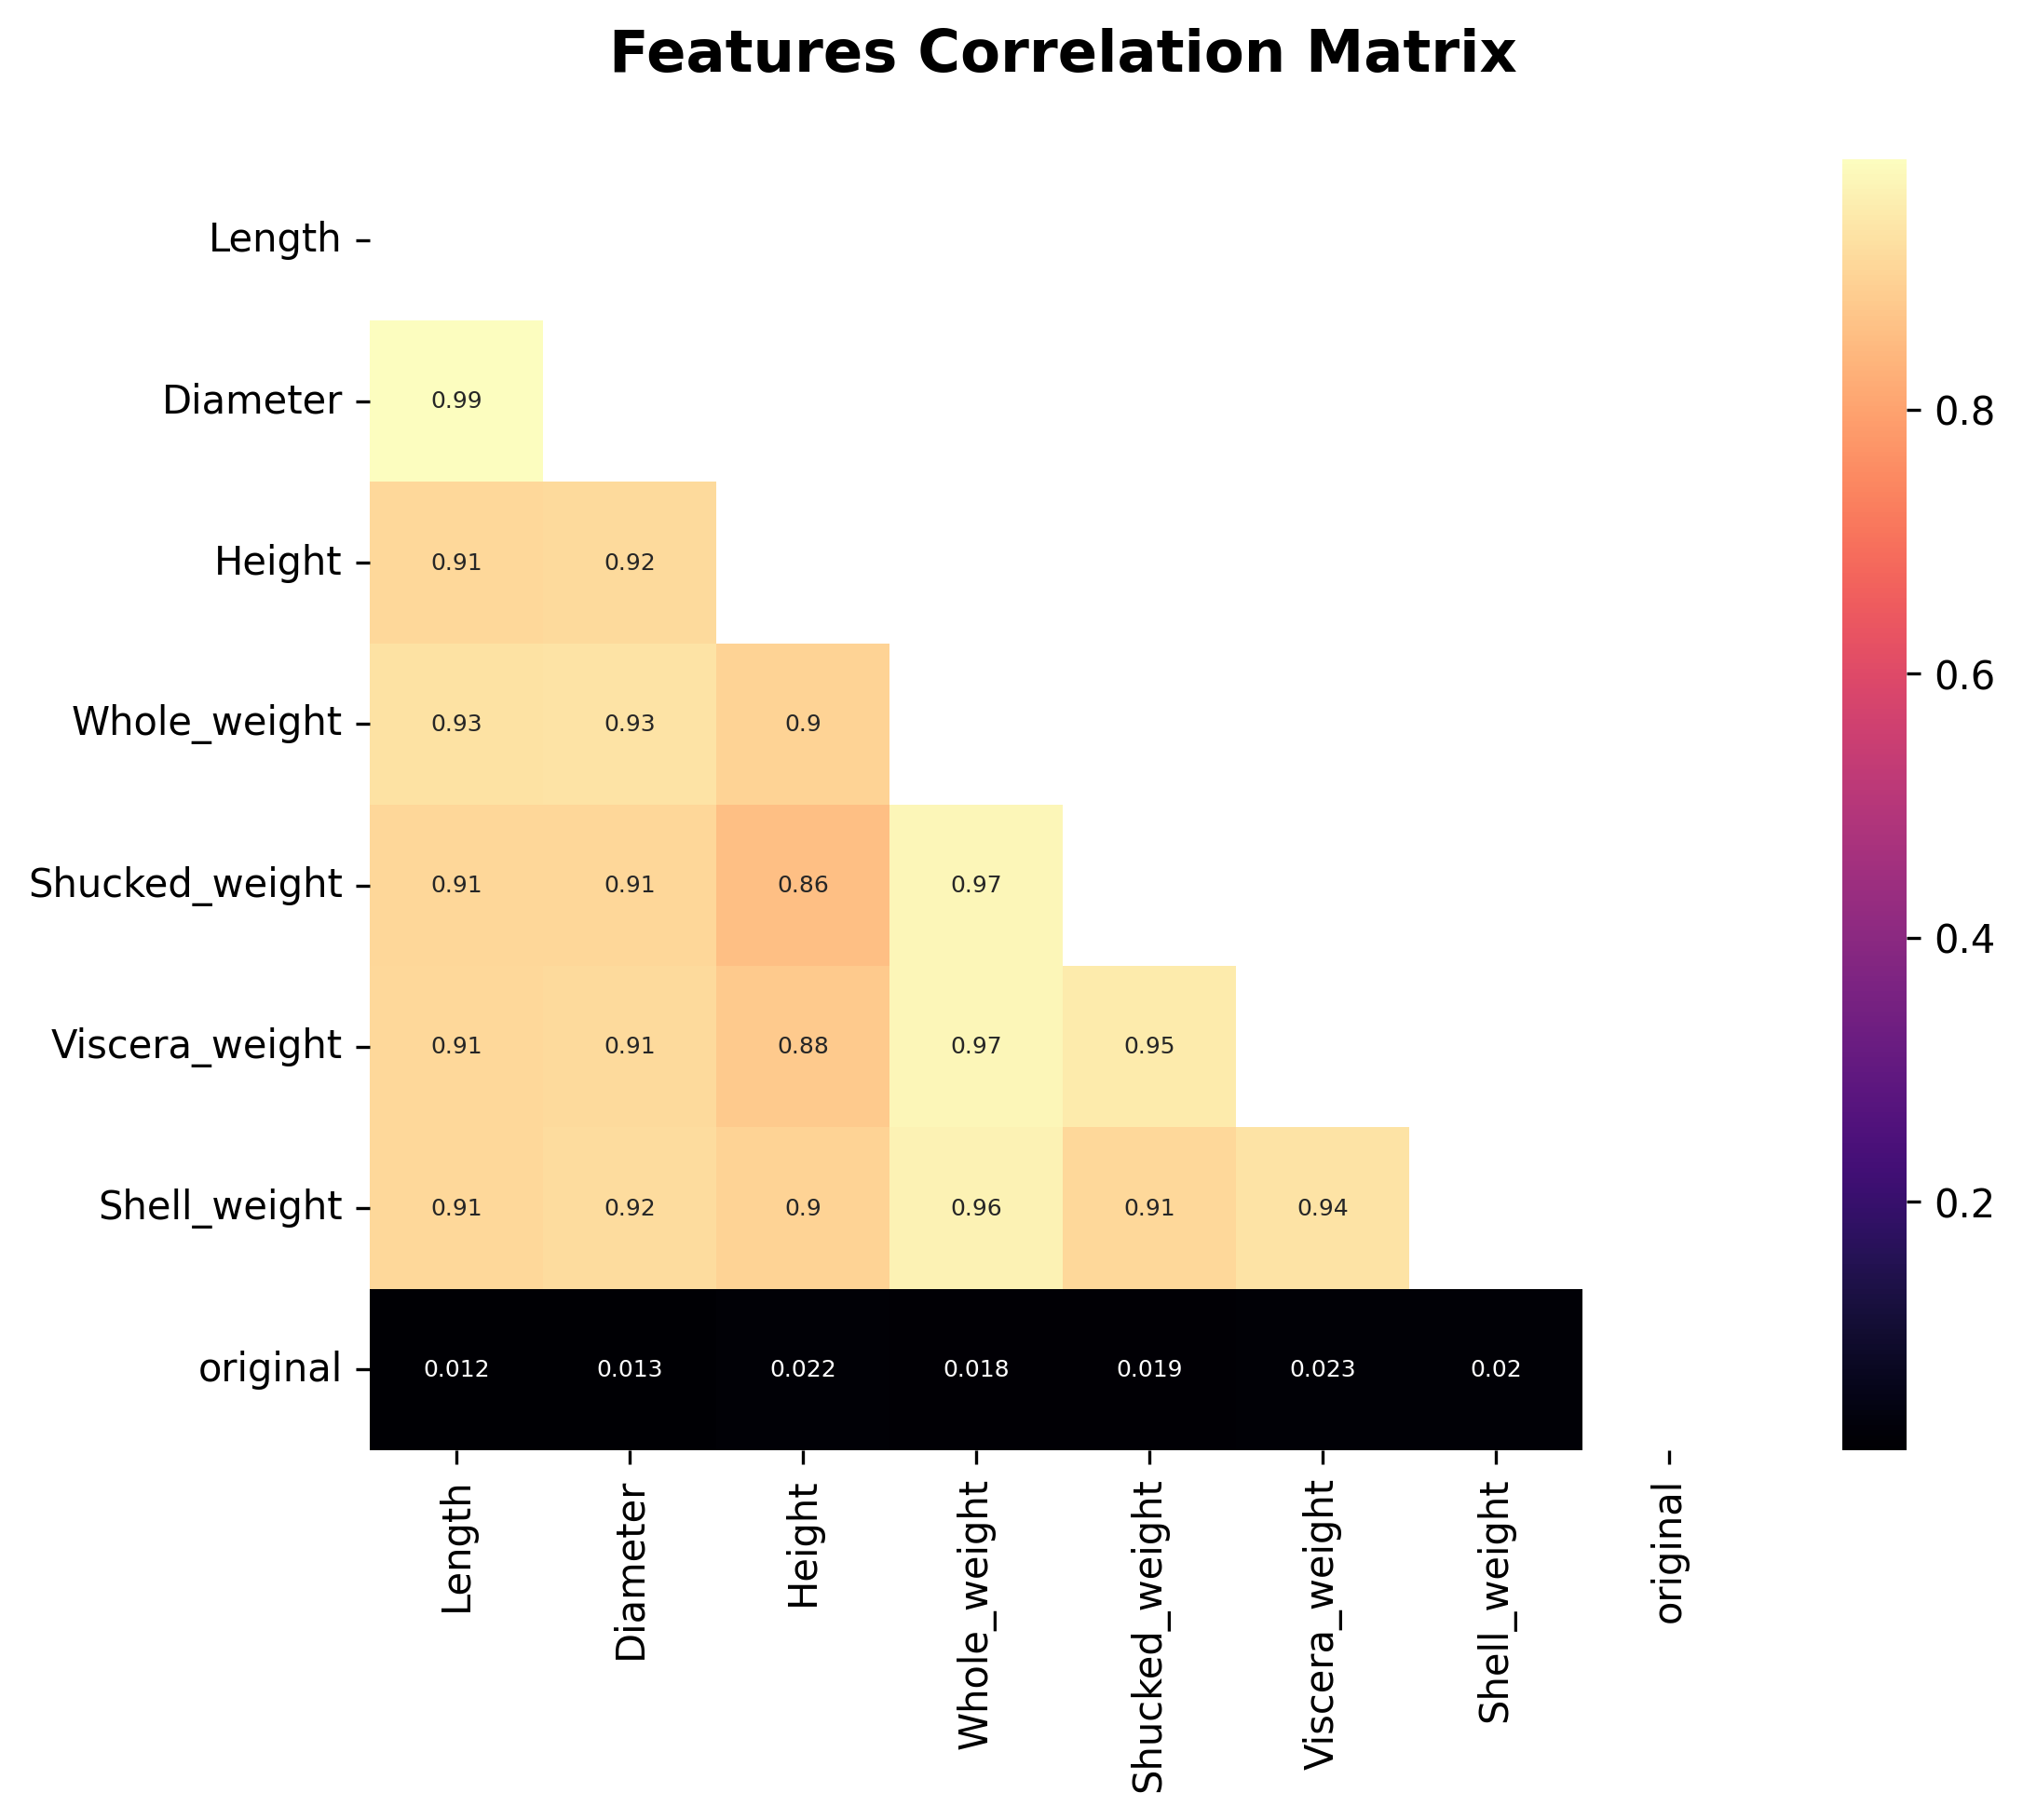

In [10]:
# Correlation of continuous data in test set
features = [f for f in test.columns if f != 'Sex']
corr = train[features].corr()
plt.figure(figsize = (8, 6), dpi = 300)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask, cmap = 'magma', annot = True, annot_kws = {'size' : 6})
plt.title('Features Correlation Matrix\n', fontsize = 15, weight = 'bold')
plt.show()

# 4. Feature Engineering

## 4.1 Basic functions

In [59]:
def MSE(y_true, y_pred):
    return np.square(np.subtract(y_true, y_pred)).mean()

def RMSE(y_true, y_pred):
    return np.sqrt(np.square(np.subtract(y_true, y_pred)).mean())

def RMSLE(y_true, y_pred):
    return np.sqrt(np.square(np.subtract(np.log(1 + y_pred), np.log(1 + y_true))).mean())

def min_max_scaler(train, test, column):
    scaler = MinMaxScaler()
    max_val = max(train[column].max(), test[column].max())
    min_val = min(train[column].min(), test[column].min())
    train[column] = (train[column] - min_val) / (max_val - min_val)
    test[column] = (test[column] - min_val) / (max_val - min_val)
    return train, test

global y_unique
y_unique=train["Rings"].unique()

def nearest(y_predicted):
    
    y_original=y_unique
    modified_prediction = np.zeros_like(y_predicted)

    for i, y_pred in enumerate(y_predicted):
        nearest_value = min(y_original, key=lambda x: abs(x - y_pred))
        modified_prediction[i] = nearest_value

    return modified_prediction

## 4.2 New Features

1. ***Top Surface Area:*** Length X Diameter
2. ***Water Loss:*** During the experiment of data collection, it is possible to have some water loss after dissecting the crab to measure different weights
3. ***Abalone Density:*** Measure of body density
4. ***BMI:*** Body Mass index
5. ***Measurement ratios:*** You can also calculate ratios like length/height, length/diameter.
6. ***Incorrect Weights:*** I have noticed that there are sub weight columns greater than the total weight of the Abalone. Part of the body cannot have more weight that the whole body

In [4]:
def new_features(data):
    df=data.copy()
    
    # Clean the weights by capping the over weights with total body weights
    df['Shell_weight']=np.where(df['Shell_weight']>df['Whole_weight'],df['Whole_weight'],df['Shell_weight'])
    df['Viscera_weight']=np.where(df['Viscera_weight']>df['Whole_weight'],df['Whole_weight'],df['Viscera_weight'])
    df['Shucked_weight']=np.where(df['Shucked_weight']>df['Whole_weight'],df['Whole_weight'],df['Shucked_weight'])
    
    # Abalone Surface area
    df["surface_area"]=df["Length"]*df["Diameter"]
    df['total_area']=2*(df["surface_area"]+df["Height"]*df["Diameter"]+df["Length"]*df["Height"])
    
    # Abalone density approx
    df['approx_density']=df['Whole_weight']/(df['surface_area']*df['Height']+1e-5)
    
    # Abalone BMI
    df['bmi']=df['Whole_weight']/(df['Height']**2+1e-5)
    
    # Measurement derived
    df["length_dia_ratio"]=df['Length']/(df['Diameter']+1e-5)
    df["length_height_ratio"]=df['Length']/(df['Height']+1e-5)
    df['shell_shuck_ratio']=df["Shell_weight"]/(df["Shucked_weight"]+1e-5)
    df['shell_viscera_ratio']=df['Shell_weight']/(df['Viscera_weight']+1e-5)
    
    df['viscera_tot_ratio']=df['Viscera_weight']/(df['Whole_weight']  +1e-5)
    df['shell_tot_ratio']=df['Shell_weight']/(df['Whole_weight']    +1e-5)
    df['shuck_tot_ratio']=df['Shucked_weight']/(df['Whole_weight']   +1e-5)
    df['shell_body_ratio']=df['Shell_weight']/(df['Shell_weight']+df['Whole_weight']+1e-5)
    df['flesh_ratio']=df['Shucked_weight']/(df['Whole_weight']+df['Shucked_weight']+1e-5)
    
    df['inv_viscera_tot']= df['Whole_weight'] / (df['Viscera_weight']+1e-5)
    df['inv_shell_tot']= df['Whole_weight'] /( df['Shell_weight']+1e-5)
    df['inv_shuck_tot']= df['Whole_weight'] / (df['Shucked_weight']+1e-5)
    
    
    # Water Loss during experiment
    df["water_loss"]=df["Whole_weight"]-df["Shucked_weight"]-df['Viscera_weight']-df['Shell_weight']
    df["water_loss"]=np.where(df["water_loss"]<0,min(df["Shucked_weight"].min(),df["Viscera_weight"].min(),df["Shell_weight"].min()),df["water_loss"])
    return df

train = new_features(train)
test = new_features(test)
original = new_features(original)

## 4.3 Data Transformation

In [60]:
# Separate labels from data
y = train["Rings"]
train = train.drop(['original', 'Rings'], axis=1)
test = test.drop(['original'], axis=1)

# Get numerical columns
columns = [col for col in train.columns if train[col].dtype not in ["object"]]

In [61]:
global unimportant_features
global overall_best_score
global overall_best_col
unimportant_features=[]
overall_best_score=1e5
overall_best_col='none'
def transform_column(train, test, columns, target):
    # Make a copy of an original dataframe
    train_copy = train.copy()
    test_copy = test.copy()
    # Get feature and score variables
    global unimportant_features
    global overall_best_score
    global overall_best_col
    # Instantiate a table with field names
    table = PrettyTable()
    table.field_names = ['Feature', 'Original RMSLE', 'Transformation', 'Tranformed RMSLE']
    # Define parameters
    epsilon = 1e-5
    power_0_25 = lambda x: np.power(x + 1 - np.min(x), 0.25)
    power_2 = lambda x: np.power(x + 1 - np.min(x), 2)
    # Define transformers
    transformer_box_cox = PowerTransformer(method = 'box-cox')
    transformer_yeo_johnson = PowerTransformer(method = 'yeo-johnson')
    transformer_power_0_25 = FunctionTransformer(power_0_25)
    transformer_power_2 = FunctionTransformer(power_2)
    # Append transformed columns to the datafame
    for col in columns:
        # Scale train and test data
        train, test = min_max_scaler(train, test, col)
        # Log transformation
        train_copy['log_'+col] = np.log1p(train_copy[col])
        test_copy['log_'+col] = np.log1p(test_copy[col])
        # Square root transformation
        train_copy['sqrt_'+col] = np.sqrt(train_copy[col])
        test_copy['sqrt_'+col] = np.sqrt(test_copy[col])
        # Box Cox transformation
        train_copy['box_cox_'+col] = transformer_box_cox.fit_transform(train_copy[[col]] + epsilon)
        test_copy['box_cox_'+col] = transformer_box_cox.fit_transform(test_copy[[col]] + epsilon)
        # Yeo Johnson transformation
        train_copy['yeo_johnson_'+col] = transformer_yeo_johnson.fit_transform(train_copy[[col]])
        test_copy['yeo_johnson_'+col] = transformer_yeo_johnson.fit_transform(test_copy[[col]])
        # **0.25 transformation
        train_copy['power_0_25_'+col] = transformer_power_0_25.fit_transform(train_copy[[col]])
        test_copy['power_0_25_'+col] = transformer_power_0_25.fit_transform(test_copy[[col]])
        # **2 transformation
        train_copy['power_0_2_'+col] = transformer_power_2.fit_transform(train_copy[[col]])
        test_copy['power_0_2_'+col] = transformer_power_2.fit_transform(test_copy[[col]])
        # Log to power transformation
        train_copy['log_sqrt_'+col] = np.log1p(np.sqrt(train_copy[col]))
        test_copy['log_sqrt_'+col] = np.log1p(np.sqrt(test_copy[col]))
        # Get transformed column names
        transformed_columns = [col, "log_"+col, "sqrt_"+col, "box_cox_"+col, "yeo_johnson_"+col,  "power_0_25_"+col , "power_0_2_"+col,"log_sqrt_"+col]
        # TruncatedSVD
        pca = TruncatedSVD(n_components=1)
        x_pca_train = pca.fit_transform(train_copy[transformed_columns])
        x_pca_test = pca.transform(test_copy[transformed_columns])
        x_pca_train = pd.DataFrame(x_pca_train, columns=[col+"_pca_comb"])
        x_pca_test = pd.DataFrame(x_pca_test, columns=[col+"_pca_comb"])
        transformed_columns.append(col+"_pca_comb")
        
        test_copy = test_copy.reset_index(drop=True)
        
        train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
        test_copy = pd.concat([test_copy, x_pca_test], axis='columns')
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        # Evaluate performance of each data transformation
        rmse_scores = []
        for t_col in transformed_columns:
            # Get array of train and test columns
            X = train_copy[[t_col]].values
            y = target.values
            # Save rmse score for every fold
            rmses = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
                model = LinearRegression()
                model.fit(X_train, np.log1p(y_train))
                y_pred = nearest(np.expm1(model.predict(x_val)))
                rmses.append(RMSE(np.log1p(y_val),np.log1p(y_pred)))
            rmse_scores.append((t_col, np.mean(rmses)))

            if overall_best_score > np.mean(rmses):
                overall_best_score = np.mean(rmses)
                overall_best_col = t_col
            if t_col == col:
                orig_rmse = np.mean(rmses)
            
        best_col, best_rmse = sorted(rmse_scores, key=lambda x: x[1], reverse=False)[0]
        cols_to_drop = [col for col in transformed_columns if col != best_col]
        final_selection = [col for col in transformed_columns if col not in cols_to_drop]
        if cols_to_drop:
            unimportant_features = unimportant_features+cols_to_drop
        table.add_row([col, orig_rmse, best_col, best_rmse])
    print(table)
    print(f"Overall best CV RMSLE score: {overall_best_score}")
    return train_copy, test_copy, transformed_columns

In [62]:
%%time
train_copy, test_copy, transformed_columns = transform_column(train, test, columns, y)

+----------------+---------------------+-------------------------+---------------------+
|    Feature     |    Original RMSLE   |      Transformation     |   Tranformed RMSLE  |
+----------------+---------------------+-------------------------+---------------------+
|     Length     | 0.20231823606252033 |     log_sqrt_Length     | 0.19974699228367676 |
|    Diameter    | 0.19961059474145842 |    log_sqrt_Diameter    | 0.19686019718117898 |
|     Height     | 0.19385045253709332 |       sqrt_Height       | 0.19117171719298903 |
|  Whole_weight  | 0.21519197208180613 |  log_sqrt_Whole_weight  | 0.19568488864750405 |
| Shucked_weight |  0.2341080988187869 | log_sqrt_Shucked_weight |  0.2145196046496908 |
| Viscera_weight |  0.2223988376634382 | log_sqrt_Viscera_weight | 0.20214067721512538 |
|  Shell_weight  | 0.19488316535508743 |  log_sqrt_Shell_weight  |  0.1820015560236911 |
+----------------+---------------------+-------------------------+---------------------+
Overall best CV RMSLE

In [65]:
# Create backup of data
train_bak = train
test_bak = test

# Copy transformed data
train = train_copy
test = test_copy

## 4.4 Numerical Clustering

In [19]:
columns

['Length',
 'Diameter',
 'Height',
 'Whole_weight',
 'Shucked_weight',
 'Viscera_weight',
 'Shell_weight']

In [64]:
train_copy["Rings"] = y

In [66]:
%%time

table = PrettyTable()
table.field_names = ['Cluster WOE Feature', 'RMSLE (CV-TRAIN)']
for col in columns:
    sub_set=[f for f in unimportant_features if col in f]
    #print(sub_set)
    temp_train=train[sub_set]
    temp_test=test[sub_set]
    sc=StandardScaler()
    temp_train=sc.fit_transform(temp_train)
    temp_test=sc.transform(temp_test)
    model = KMeans()

    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=5)
    kmeans.fit(np.array(temp_train))
    labels_train = kmeans.labels_

    train[col+"_unimp_cluster_WOE"] = labels_train
    test[col+"_unimp_cluster_WOE"] = kmeans.predict(np.array(temp_test))
    
    kf=KFold(n_splits=5, shuffle=True, random_state=42)
    
    X=train[[col+"_unimp_cluster_WOE"]].values
    y=train[target].values

    best_rmse=[]
    for train_idx, val_idx in kf.split(X,y):
        X_train,y_train=X[train_idx],y[train_idx]
        x_val,y_val=X[val_idx],y[val_idx]
        model=LinearRegression()
        model.fit(X_train,np.log1p(y_train))
        y_pred=nearest(np.expm1(model.predict(x_val)))
        best_rmse.append(RMSE(np.log1p(y_val),np.log1p(y_pred)))
        
    table.add_row([col+"_unimp_cluster_WOE",np.mean(best_rmse)])
    if overall_best_score<np.mean(best_rmse):
            overall_best_score=np.mean(best_rmse)
            overall_best_col=col+"_unimp_cluster_WOE"
    
print(table)

+----------------------------------+---------------------+
|       Cluster WOE Feature        |   RMSLE (CV-TRAIN)  |
+----------------------------------+---------------------+
|     Length_unimp_cluster_WOE     |  0.2850437128345247 |
|    Diameter_unimp_cluster_WOE    |  0.2798339097665715 |
|     Height_unimp_cluster_WOE     |  0.2889457301080228 |
|  Whole_weight_unimp_cluster_WOE  |  0.2868969299966239 |
| Shucked_weight_unimp_cluster_WOE | 0.27254983456122855 |
| Viscera_weight_unimp_cluster_WOE |  0.2868969299966239 |
|  Shell_weight_unimp_cluster_WOE  |  0.2498080140535702 |
+----------------------------------+---------------------+
CPU times: user 13.1 s, sys: 2.05 s, total: 15.2 s
Wall time: 10.9 s


In [8]:
# Get transformed columns
important_features = [col for col in train_copy.columns if col not in unimportant_features]

# Replace original dataframe with important features
train = train_copy[important_features]
test = test_copy[important_features]

In [25]:
train = train_copy
test = test_copy

## 4.4 Encode categorical data

Encode categorical data using `One-Hot` encoding method

In [67]:
cat_cols = [f for f in test.columns if (train[f].dtype != 'O' and train[f].nunique()<2000 and train[f].nunique()>2 and "WOE" not in f) or (train[f].dtype == 'O') ]
print(train[cat_cols].nunique())

Sex                              3
Length                         157
Diameter                       126
Height                          90
Shucked_weight                1806
Viscera_weight                 983
Shell_weight                  1132
log_Length                     157
sqrt_Length                    157
box_cox_Length                 157
yeo_johnson_Length             157
power_0_25_Length              157
power_0_2_Length               157
log_sqrt_Length                157
Length_pca_comb                158
log_Diameter                   126
sqrt_Diameter                  126
box_cox_Diameter               126
yeo_johnson_Diameter           126
power_0_25_Diameter            126
power_0_2_Diameter             126
log_sqrt_Diameter              126
Diameter_pca_comb              129
log_Height                      90
sqrt_Height                     90
box_cox_Height                  90
yeo_johnson_Height              90
power_0_25_Height               90
power_0_2_Height    

In [37]:
train_bak = train
test_bak = test

In [41]:
train = train_bak
test = test_bak

In [48]:
cat_cols

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Shucked_weight',
 'Viscera_weight',
 'Shell_weight',
 'log_Length',
 'sqrt_Length',
 'box_cox_Length',
 'yeo_johnson_Length',
 'power_0_25_Length',
 'power_0_2_Length',
 'log_sqrt_Length',
 'Length_pca_comb',
 'log_Diameter',
 'sqrt_Diameter',
 'box_cox_Diameter',
 'yeo_johnson_Diameter',
 'power_0_25_Diameter',
 'power_0_2_Diameter',
 'log_sqrt_Diameter',
 'Diameter_pca_comb',
 'log_Height',
 'sqrt_Height',
 'box_cox_Height',
 'yeo_johnson_Height',
 'power_0_25_Height',
 'power_0_2_Height',
 'log_sqrt_Height',
 'Height_pca_comb',
 'log_Shucked_weight',
 'sqrt_Shucked_weight',
 'box_cox_Shucked_weight',
 'yeo_johnson_Shucked_weight',
 'power_0_25_Shucked_weight',
 'power_0_2_Shucked_weight',
 'log_sqrt_Shucked_weight',
 'Shucked_weight_pca_comb',
 'log_Viscera_weight',
 'sqrt_Viscera_weight',
 'box_cox_Viscera_weight',
 'yeo_johnson_Viscera_weight',
 'power_0_25_Viscera_weight',
 'power_0_2_Viscera_weight',
 'log_sqrt_Viscera_weight',
 'Visc

In [68]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.fit_transform(test['Sex'])

In [73]:
final_drop_list=[]

table = PrettyTable()
table.field_names = ['Original', 'Final Transformation', "RMSLE(CV)- Regression"]
dt_params={'criterion': 'absolute_error'}
threshold=0.85
# It is possible that multiple parent features share same child features, so store selected features to avoid selecting the same feature again
best_cols=[]

for col in columns:
    sub_set=[f for f in train.columns if col in f and train[f].nunique()>100]
    print(sub_set)
    if len(sub_set)>2:
        correlated_features = []

        for i, feature in enumerate(sub_set):
            # Check correlation with all remaining features
            for j in range(i+1, len(sub_set)):
                correlation = np.abs(train[feature].corr(train[sub_set[j]]))
                # If correlation is greater than threshold, add to list of highly correlated features
                if correlation > threshold:
                    correlated_features.append(sub_set[j])

        # Remove duplicate features from the list
        correlated_features = list(set(correlated_features))
        print(correlated_features)
        if len(correlated_features)>=2:

            temp_train=train[correlated_features]
            temp_test=test[correlated_features]
            #Scale before applying PCA
            sc=StandardScaler()
            temp_train=sc.fit_transform(temp_train)
            temp_test=sc.transform(temp_test)

            # Initiate PCA
            pca=TruncatedSVD(n_components=1)
            x_pca_train=pca.fit_transform(temp_train)
            x_pca_test=pca.transform(temp_test)
            x_pca_train=pd.DataFrame(x_pca_train, columns=[col+"_pca_comb_final"])
            x_pca_test=pd.DataFrame(x_pca_test, columns=[col+"_pca_comb_final"])
            train=pd.concat([train,x_pca_train],axis='columns')
            test=pd.concat([test,x_pca_test],axis='columns')

            # Clustering
            model = KMeans()
            kmeans = KMeans(n_clusters=28)
            kmeans.fit(np.array(temp_train))
            labels_train = kmeans.labels_

            train[col+'_final_cluster'] = labels_train
            test[col+'_final_cluster'] = kmeans.predict(np.array(temp_test))

            cat_labels=cat_labels=train.groupby([col+"_final_cluster"])[target].mean()
            cat_labels2=cat_labels.to_dict()
            train[col+"_final_cluster"]=train[col+"_final_cluster"].map(cat_labels2)
            test[col+"_final_cluster"]=test[col+"_final_cluster"].map(cat_labels2)

            correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]

            # See which transformation along with the original is giving you the best univariate fit with target
            kf=KFold(n_splits=5, shuffle=True, random_state=42)

            rmse_scores = []

            for f in transformed_columns:
                X = train_copy[[f]].values
                y = train_copy[target].astype(int).values

                rmses = []
                for train_idx, val_idx in kf.split(X, y):
                    X_train, y_train = X[train_idx], y[train_idx]
                    x_val, y_val = X[val_idx], y[val_idx]
                    model=LinearRegression()
                    model.fit(X_train,np.log1p(y_train))
                    y_pred=nearest(np.expm1(model.predict(x_val)))
                    rmses.append(RMSE(np.log1p(y_val),np.log1p(y_pred)))
                    
                if f not in best_cols:
                    rmse_scores.append((f,np.mean(rmses)))
            best_col, best_rmse=sorted(rmse_scores, key=lambda x:x[1], reverse=False)[0]
            best_cols.append(best_col)

            cols_to_drop = [f for f in correlated_features if  f not in best_cols]
            if cols_to_drop:
                final_drop_list=final_drop_list+cols_to_drop
            table.add_row([col, best_col, best_rmse])

print(table)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [26]:
def encode(df, enc):
    """
    Transform categorical features using one-hot encoding method
    """
    cat_features = ["Sex"]
    transformer  = ColumnTransformer([("one_hot",
                                        enc,
                                        cat_features)],
                                        remainder="passthrough")
    return pd.DataFrame(transformer.fit_transform(df))

In [27]:
# Transform train data
transformed_X = encode(train, OneHotEncoder())
train = transformed_X

# Transform test data
transformed_test = encode(test, OneHotEncoder())
test = transformed_test

## 4.5 Save data

Save prepared data to a file

In [11]:
train.to_csv('data/prepared_train.csv', index=False)
test.to_csv('data/prepared_test.csv', index=False)
y.to_csv('data/targets.csv', index=False)

# 5. Creating a model

In [2]:
# Reimport data
train = pd.read_csv('data/prepared_train.csv')
test = pd.read_csv('data/prepared_test.csv')
submission = pd.read_csv('data/sample_submission.csv')
y = pd.read_csv('data/targets.csv')

# Convert target to Pandas Series
y = y.to_dict('dict')['Rings']
y = pd.Series(data=y.values(), index=y.keys())

## 5.1 XGBoost Regression

### 5.1.1 Automatic hyperparameter tuning

Hyperparameter tuning with `optuna`

In [6]:
%%time
def objective(trial, data=train, target=y, average=0):
    param = {
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [300]),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['rmsle']),
        'objective': trial.suggest_categorical('objective', ['reg:squarederror']),
        'device' : trial.suggest_categorical('device', ['cuda']),
        'tree_method': trial.suggest_categorical('tree_method', ['hist']),  # this parameter means using the GPU when training our model to speedup the training process
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_float('gamma', 0.0, 5),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'eta': trial.suggest_float('subsample', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'max_bin': trial.suggest_int('max_bin', 255, 8192),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('lambda', 1.0, 100.0),
        'reg_alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
    }

    # Count folds
    c = 1
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(data, target):
        print(f"Fold {c}")
        X_train, y_train = data.iloc[train_idx], target.iloc[train_idx]
        x_val, y_val = data.iloc[val_idx], target.iloc[val_idx]
        xgbr_model = TransformedTargetRegressor(xgb.XGBRegressor(**param),
                                                func=np.log1p,
                                                inverse_func=np.expm1)
        xgbr_model.fit(X_train, y_train, eval_set=[(x_val,y_val)],verbose=0,callbacks=[EarlyStopping(rounds = 300,save_best=True)])
        y_preds = xgbr_model.predict(x_val)
        rmsle = RMSLE(y_val, y_preds)
        average += rmsle
        c += 1
    gc.collect()
    return average/(c-1)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2024-04-26 20:35:27,249] A new study created in memory with name: no-name-4ccd6ea2-4ba0-42fe-9c0d-2bd3bbef9fc7


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:35:40,668] Trial 0 finished with value: 0.15595720281453646 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.010918911554652478, 'gamma': 1.0784751846112788, 'subsample': 0.1187557399172939, 'max_depth': 5, 'max_bin': 1095, 'colsample_bytree': 0.7607909871246251, 'lambda': 82.12151156558491, 'alpha': 0.9951667282026627, 'colsample_bylevel': 0.8, 'random_state': 42, 'min_child_weight': 2}. Best is trial 0 with value: 0.15595720281453646.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:35:51,077] Trial 1 finished with value: 0.16182185485414322 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.031323964229051066, 'gamma': 1.8400140662340774, 'subsample': 0.18611633557103496, 'max_depth': 1, 'max_bin': 6489, 'colsample_bytree': 0.12404626033410454, 'lambda': 65.1192487240387, 'alpha': 0.010457910412526021, 'colsample_bylevel': 0.8, 'random_state': 42, 'min_child_weight': 1}. Best is trial 0 with value: 0.15595720281453646.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:36:07,298] Trial 2 finished with value: 0.15279861784418675 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.03783703641963133, 'gamma': 0.1257310470141526, 'subsample': 0.3990928943372396, 'max_depth': 8, 'max_bin': 1025, 'colsample_bytree': 0.14474676609670076, 'lambda': 16.153150238361572, 'alpha': 1.0071397407334306, 'colsample_bylevel': 0.6, 'random_state': 42, 'min_child_weight': 1}. Best is trial 2 with value: 0.15279861784418675.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:36:22,882] Trial 3 finished with value: 0.1585650093587781 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.018090677458917116, 'gamma': 3.5469067326608044, 'subsample': 0.9359338309519984, 'max_depth': 8, 'max_bin': 1757, 'colsample_bytree': 0.10088355206262441, 'lambda': 14.314775160294296, 'alpha': 0.04361369605967703, 'colsample_bylevel': 0.8, 'random_state': 42, 'min_child_weight': 4}. Best is trial 2 with value: 0.15279861784418675.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:36:41,809] Trial 4 finished with value: 0.151834998272472 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.04347711696479569, 'gamma': 0.9196259677774737, 'subsample': 0.8300406592309745, 'max_depth': 5, 'max_bin': 6098, 'colsample_bytree': 0.5314425803301028, 'lambda': 1.3783130403438977, 'alpha': 0.0023928354906307143, 'colsample_bylevel': 0.6, 'random_state': 42, 'min_child_weight': 2}. Best is trial 4 with value: 0.151834998272472.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:36:50,874] Trial 5 finished with value: 0.16118716011427206 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.02088604343864415, 'gamma': 4.171724519253887, 'subsample': 0.6264490158425362, 'max_depth': 2, 'max_bin': 1370, 'colsample_bytree': 0.13970608485655503, 'lambda': 3.415525973354941, 'alpha': 0.23998317883467812, 'colsample_bylevel': 0.4, 'random_state': 42, 'min_child_weight': 1}. Best is trial 4 with value: 0.151834998272472.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:37:03,262] Trial 6 finished with value: 0.1567569048814109 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.03230240977280177, 'gamma': 4.540896470742824, 'subsample': 0.20051880415432258, 'max_depth': 5, 'max_bin': 2796, 'colsample_bytree': 0.43700993185384784, 'lambda': 14.408917371655829, 'alpha': 1.364854766045404, 'colsample_bylevel': 0.8, 'random_state': 42, 'min_child_weight': 4}. Best is trial 4 with value: 0.151834998272472.


Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


[I 2024-04-26 20:37:22,529] Trial 7 finished with value: 0.1533960475858906 and parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.04827020159595809, 'gamma': 2.443112531815635, 'subsample': 0.5677241802056778, 'max_depth': 9, 'max_bin': 7244, 'colsample_bytree': 0.8970924464111271, 'lambda': 89.70695634265077, 'alpha': 0.021874236750548275, 'colsample_bylevel': 0.3, 'random_state': 42, 'min_child_weight': 3}. Best is trial 4 with value: 0.151834998272472.


Fold 1
Fold 2
Fold 3


[W 2024-04-26 20:37:25,936] Trial 8 failed with parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.01309156366650105, 'gamma': 2.9355948844925766, 'subsample': 0.5464592629198901, 'max_depth': 7, 'max_bin': 255, 'colsample_bytree': 0.6352542893758094, 'lambda': 61.99260056226379, 'alpha': 0.06288417895001706, 'colsample_bylevel': 0.3, 'random_state': 42, 'min_child_weight': 4} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/kostas/Documents/git/Python_Venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<timed exec>", line 38, in objective
  File "/home/kostas/Documents/git/Python_Venv/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, 

Fold 4


KeyboardInterrupt: 

In [7]:
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Mean RMSLE value:', study.best_trial.value)

Number of finished trials: 9
Best trial parameters: {'n_jobs': -1, 'n_estimators': 300, 'grow_policy': 'depthwise', 'eval_metric': 'rmsle', 'objective': 'reg:squarederror', 'device': 'cuda', 'tree_method': 'hist', 'learning_rate': 0.04347711696479569, 'gamma': 0.9196259677774737, 'subsample': 0.8300406592309745, 'max_depth': 5, 'max_bin': 6098, 'colsample_bytree': 0.5314425803301028, 'lambda': 1.3783130403438977, 'alpha': 0.0023928354906307143, 'colsample_bylevel': 0.6, 'random_state': 42, 'min_child_weight': 2}
Mean RMSLE value: 0.151834998272472


### 5.1.2 Manual hyperparameter tuning

Manual fine-tuning of parameters set by `optuna`

In [8]:
xgbr_params = study.best_trial.params
xgbr_params

{'n_jobs': -1,
 'n_estimators': 300,
 'grow_policy': 'depthwise',
 'eval_metric': 'rmsle',
 'objective': 'reg:squarederror',
 'device': 'cuda',
 'tree_method': 'hist',
 'learning_rate': 0.04347711696479569,
 'gamma': 0.9196259677774737,
 'subsample': 0.8300406592309745,
 'max_depth': 5,
 'max_bin': 6098,
 'colsample_bytree': 0.5314425803301028,
 'lambda': 1.3783130403438977,
 'alpha': 0.0023928354906307143,
 'colsample_bylevel': 0.6,
 'random_state': 42,
 'min_child_weight': 2}

In [13]:
xgbr_params = {
 'n_jobs': -1,
 'n_estimators': 3000,
 'grow_policy': 'depthwise',
 'eval_metric': 'rmsle',
 'objective': 'reg:squarederror',
 'device': 'cuda',
 'tree_method': 'hist',
 'learning_rate': 0.04347711696479569,
 'gamma': 0.9196259677774737,
 'subsample': 0.8300406592309745,
 'max_depth': 5,
 'max_bin': 6098,
 'colsample_bytree': 0.5314425803301028,
 'lambda': 1.3783130403438977,
 'alpha': 0.0023928354906307143,
 'colsample_bylevel': 0.6,
 'random_state': 42,
 'min_child_weight': 2
}

In [9]:
%%time
def xgbr_cross_val(train, y, test, params, average=0):
    """
    Do a K-Fold data cross-validation on a trained XGBRegressor model
    """
    # Make a copy of an original training data set
    train_fold = train.copy()
    y_fold = y.copy()
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Prepare data for cross-valdiation split
    X = train_fold
    y = y_fold

    # Instantiate PrettyTable
    table = PrettyTable()
    table.field_names = ['Fold', 'Train RMSLE', 'Test RMSLE', 'Average RMSLE']
    
    # Define best score (set to a high value as lower the score, the better)
    best_score = 1e5

    # Count folds
    c = 1

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(X, y):
        print(f"{c} fold")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        xgbr_model = xgb.XGBRegressor(**params)
        xgbr_model.fit(X_train, y_train, eval_set=[(x_val,y_val)],verbose=0,callbacks=[EarlyStopping(rounds = 500,save_best=True)])
        y_preds = xgbr_model.predict(x_val)
        rmsle = RMSLE(y_val, y_preds)
        average += rmsle
        table.add_row([c, xgbr_model.best_score, rmsle, average/c])
        if xgbr_model.best_score < best_score:
            best_score = rmsle
        c += 1

    # Print table
    print(table)
    
    # Print RMSLE stats
    print(f"Best RMSLE: {best_score}, mean RMSLE: {average/(c-1)}")

    # Collect garbage
    gc.collect()
    return best_score

best_score = xgbr_cross_val(train, y, test, xgbr_params)

1 fold
2 fold
3 fold
4 fold
5 fold
6 fold
7 fold
8 fold
9 fold
10 fold
+------+---------------------+---------------------+---------------------+
| Fold |     Train RMSLE     |      Test RMSLE     |    Average RMSLE    |
+------+---------------------+---------------------+---------------------+
|  1   |  0.1510431940335102 | 0.15104318938812147 | 0.15104318938812147 |
|  2   |  0.1526302625347687 | 0.15263026451942638 | 0.15183672695377393 |
|  3   | 0.14811688752259602 | 0.14811690438880012 | 0.15059678609878266 |
|  4   | 0.15463000480270772 | 0.15463000113762354 | 0.15160508985849286 |
|  5   | 0.15368654313056115 | 0.15368654689457775 | 0.15202138126570983 |
|  6   |  0.1481388070114963 |  0.1481388301591967 |  0.1513742894146243 |
|  7   |  0.1523933820519759 | 0.15239340474330298 | 0.15151987731872124 |
|  8   | 0.15078622319026044 | 0.15078623543172073 | 0.15142817208284617 |
|  9   | 0.14935372796836102 | 0.14935374123372128 | 0.15119767976627674 |
|  10  |  0.1480991511060053 

In [14]:
%%time

# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.15)

# Instantiate a model
xgbr_model = xgb.XGBRegressor(**xgbr_params)

# Fit the model with training data
xgbr_model.fit(X_train, y_train, eval_set=[(X_test,y_test)],verbose=2,callbacks=[EarlyStopping(rounds = 500,save_best=True)])
predictions = xgbr_model.predict(test)

[0]	validation_0-rmsle:0.28026
[2]	validation_0-rmsle:0.26579
[4]	validation_0-rmsle:0.25270
[6]	validation_0-rmsle:0.24079
[8]	validation_0-rmsle:0.23030
[10]	validation_0-rmsle:0.22089
[12]	validation_0-rmsle:0.21257
[14]	validation_0-rmsle:0.20527
[16]	validation_0-rmsle:0.19863
[18]	validation_0-rmsle:0.19286
[20]	validation_0-rmsle:0.18772
[22]	validation_0-rmsle:0.18333
[24]	validation_0-rmsle:0.17934
[26]	validation_0-rmsle:0.17586
[28]	validation_0-rmsle:0.17287
[30]	validation_0-rmsle:0.17023
[32]	validation_0-rmsle:0.16797
[34]	validation_0-rmsle:0.16597
[36]	validation_0-rmsle:0.16420
[38]	validation_0-rmsle:0.16265
[40]	validation_0-rmsle:0.16139
[42]	validation_0-rmsle:0.16022
[44]	validation_0-rmsle:0.15926
[46]	validation_0-rmsle:0.15845
[48]	validation_0-rmsle:0.15767
[50]	validation_0-rmsle:0.15704
[52]	validation_0-rmsle:0.15648
[54]	validation_0-rmsle:0.15600
[56]	validation_0-rmsle:0.15560
[58]	validation_0-rmsle:0.15521
[60]	validation_0-rmsle:0.15491
[62]	validati

KeyboardInterrupt: 

In [29]:
# Create submission

submission["Rings"] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Rings
0,90615,10.080867
1,90616,9.881035
2,90617,10.141693
3,90618,10.567669
4,90619,7.557144


In [20]:
# Create submission

submission["Rings"] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Rings
0,90615,9.893328
1,90616,9.753872
2,90617,9.807108
3,90618,10.339102
4,90619,7.653876


## 5.2 CatBoost Regression

Tune hyperparameters and cross-validate Catboost regressor

### 5.2.1 Hyperparameter tuning

In [37]:
%%time
def objective(trial, data=train, target=y, average=0):
    param = {
        'iterations': trial.suggest_categorical('iterations', [300]),
        "verbose": trial.suggest_categorical('verbose', [False]),
        'depth': trial.suggest_int('depth', 6, 10),
        'max_bin': trial.suggest_int('max_bin', 128, 2048),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'max_leaves': trial.suggest_int('max_leaves', 2, 64),
        'eval_metric': trial.suggest_categorical('eval_metric', ['Quantile']),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE']),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli']),
        "grow_policy": trial.suggest_categorical('grow_policy', ['Lossguide']),
        "task_type": trial.suggest_categorical('task_type', ["GPU"]),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        #'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        "random_state": trial.suggest_categorical('random_state', [42]),
        "early_stopping_rounds": trial.suggest_categorical('early_stopping_rounds', [300])
    }
    
    # Count folds
    c = 1
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(data, target):
        X_train, y_train = data.iloc[train_idx], target.iloc[train_idx]
        x_val, y_val = data.iloc[val_idx], target.iloc[val_idx]
        # Get training and testing data
        train = Pool(data=X_train, label=y_train)
        evaluate = Pool(data=x_val, label=y_val)
        # Instantiate the model
        model = CatBoostRegressor(**param)
        # Fit the model
        model.fit(train, use_best_model=True, eval_set=evaluate)
        y_preds = model.predict(x_val)
        rmsle = RMSLE(y_val, y_preds)
        average += rmsle
        c += 1
    gc.collect()
    return average/(c-1)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best trial value:', study.best_trial.value)

[I 2024-04-26 16:47:15,748] A new study created in memory with name: no-name-3c8e7f1d-94bb-4102-be4f-c0e020cc6c40
[I 2024-04-26 16:47:48,598] Trial 0 finished with value: 0.15502716851282575 and parameters: {'iterations': 300, 'verbose': False, 'depth': 10, 'max_bin': 702, 'l2_leaf_reg': 56.6113102919134, 'min_data_in_leaf': 83, 'random_strength': 9.027185634486097, 'learning_rate': 0.00780643789072476, 'max_leaves': 41, 'eval_metric': 'Quantile', 'loss_function': 'RMSE', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'task_type': 'GPU', 'subsample': 0.6407534968891974, 'random_state': 42, 'early_stopping_rounds': 300}. Best is trial 0 with value: 0.15502716851282575.
[I 2024-04-26 16:48:27,066] Trial 1 finished with value: 0.16541179431703024 and parameters: {'iterations': 300, 'verbose': False, 'depth': 8, 'max_bin': 651, 'l2_leaf_reg': 84.2535316480762, 'min_data_in_leaf': 95, 'random_strength': 1.36510421761117, 'learning_rate': 0.005102477493003786, 'max_leaves': 61, '

Number of finished trials: 30
Best trial parameters: {'iterations': 300, 'verbose': False, 'depth': 10, 'max_bin': 1158, 'l2_leaf_reg': 31.80480657168747, 'min_data_in_leaf': 20, 'random_strength': 2.32234712463821, 'learning_rate': 0.061882021628170504, 'max_leaves': 57, 'eval_metric': 'Quantile', 'loss_function': 'RMSE', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Lossguide', 'task_type': 'GPU', 'subsample': 0.8982882178328477, 'random_state': 42, 'early_stopping_rounds': 300}
Best trial value: 0.1501524728524725
CPU times: user 25min 7s, sys: 6min 52s, total: 32min
Wall time: 18min 14s


In [51]:
cat_params = study.best_trial.params
cat_params

{'num_iterations': 300,
 'device': 'gpu',
 'n_jobs': -1,
 'verbose': -1,
 'max_depth': 9,
 'num_leaves': 574,
 'subsample_freq': 2,
 'random_state': 42,
 'min_child_samples': 129,
 'reg_alpha': 0.5301668840339838,
 'reg_lambda': 6.982504291787756,
 'subsample': 0.5758089886012983,
 'learning_rate': 0.03163930083489183,
 'colsample_bytree': 0.927264234013095,
 'min_child_weight': 15.074924797971464}

In [55]:
cat_params = {
 'iterations': 30,
 'verbose': False,
 'depth': 10,
 'max_bin': 1158,
 'l2_leaf_reg': 31.80480657168747,
 'min_data_in_leaf': 20,
 'random_strength': 2.32234712463821,
 'learning_rate': 0.061882021628170504,
 'max_leaves': 57,
 'eval_metric': 'Quantile',
 'loss_function': 'RMSE',
 'bootstrap_type': 'Bernoulli',
 'grow_policy': 'Lossguide',
 'task_type': 'GPU',
 'subsample': 0.8982882178328477,
 'random_state': 42,
 'early_stopping_rounds': 300
}

### 5.2.2 Cross Validation

In [42]:
%%time

def cat_cross_val(train, y, test, param, average=0):
    """
    Do a K-Fold data cross-validation on a trained CatBoost Regressor model
    """
    # Make a copy of an original training data set
    train_fold = train.copy()
    y_fold = y.copy()
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Prepare data for cross-valdiation split
    X = train_fold
    y = y_fold

    # Instantiate PrettyTable
    table = PrettyTable()
    table.field_names = ['Fold', 'Learn RMSE', 'Validation RMSE', 'Validation RMSLE', 'Mean RMSLE']
    
    # Define best score (set to a high value as lower the score, the better)
    best_score = 1e5

    # Count folds
    c = 1

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(X, y):
        print(f"{c} fold")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        # Get training and testing data
        train = Pool(data=X_train, label=y_train)
        evaluate = Pool(data=x_val, label=y_val)
        cat_model = CatBoostRegressor(**param)
        cat_model.fit(train, use_best_model=True, eval_set=evaluate)
        y_preds = cat_model.predict(x_val)
        rmsle = RMSLE(y_val, y_preds)
        average += rmsle
        table.add_row([c, cat_model.get_best_score()['learn']['RMSE'], cat_model.get_best_score()['validation']['RMSE'], rmsle, average/c])
        c += 1
    print(table)
    print(f"Best RMSLE score: {best_score}, mean RMSLE score: {average/(c-1)}")
    return best_score

best_score = cat_cross_val(train, y, test, cat_params)

1 fold
2 fold
3 fold
4 fold
5 fold
6 fold
7 fold
8 fold
9 fold
10 fold
+------+--------------------+--------------------+---------------------+---------------------+
| Fold |     Learn RMSE     |  Validation RMSE   |   Validation RMSLE  |      Mean RMSLE     |
+------+--------------------+--------------------+---------------------+---------------------+
|  1   | 1.4451358244694978 | 1.846721138650131  | 0.14981387400690058 | 0.14981387400690058 |
|  2   | 1.3020456046046804 | 1.8411733654071538 | 0.15153672161381723 |  0.1506752978103589 |
|  3   | 1.4217985251395877 | 1.8220250074887383 | 0.14735103100533048 | 0.14956720887534944 |
|  4   | 1.5345974427901135 | 1.8494808387285706 | 0.15406268334876616 |  0.1506910774937036 |
|  5   | 1.435552187544691  | 1.8501640912420645 | 0.15262983853987985 | 0.15107882970293887 |
|  6   | 1.5056846770644527 | 1.840150138236904  | 0.14692346363164369 | 0.15038626869105634 |
|  7   | 1.375232479816461  | 1.8516352238037612 |  0.1512821406341658 | 0

In [60]:
%%time

# Train test split
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.15)

# Pool data
train = Pool(data=X_train, label=y_train)
evaluate = Pool(data=X_test, label=y_test)

# Instantiate the model
cat_model = CatBoostRegressor(**cat_params)

# Fit the model
cat_model.fit(train, use_best_model=True, eval_set=evaluate)

# Make predictions
predictions = cat_model.predict(test)

TypeError: Singleton array array(<catboost.core.Pool object at 0x796638b86270>, dtype=object) cannot be considered a valid collection.

In [58]:
# Create submission

submission["Rings"] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Rings
0,90615,9.788192
1,90616,9.762524
2,90617,9.986214
3,90618,10.047297
4,90619,7.863809


In [36]:
print(f"Best RMSLE score with {cat_params['iterations']} iterations is: {best_score}")

Best RMSLE score with 300 iterations is: 0.147160236854646


## 5.3 LightGBM Regression

### 5.3.1 Hyperparameter Tuning

In [49]:
%%time
def objective(trial, data=train, target=y, average=0):
    param = {
        'num_iterations': trial.suggest_categorical('num_iterations', [300]),
        'device': trial.suggest_categorical('device', ['gpu']),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
        'verbose': trial.suggest_categorical('verbose', [-1]),
        'max_depth': trial.suggest_int('max_depth', 6, 10),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'subsample_freq': trial.suggest_int("subsample_freq", 1, 7),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1, 10.0),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1., 50.),
    }

    # Count folds
    c = 1
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(data, target):
        X_train, y_train = data.iloc[train_idx], target.iloc[train_idx]
        x_val, y_val = data.iloc[val_idx], target.iloc[val_idx]
        lgbm_model = LGBMRegressor(**param)
        lgbm_model.fit(X_train, y_train, eval_set=[(x_val,y_val)],eval_names=["valid"],eval_metric=['MSLE'])
        y_preds = lgbm_model.predict(x_val)
        rmsle = RMSLE(y_val, y_preds)
        average += rmsle
        c += 1
    return average/(c-1)

CPU times: user 10 µs, sys: 1e+03 ns, total: 11 µs
Wall time: 18.4 µs


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best trial value:', study.best_trial.value)

In [48]:
lgbm_params = study.best_trial.params
lgbm_params

{'num_iterations': 300,
 'device': 'gpu',
 'n_jobs': -1,
 'verbose': -1,
 'max_depth': 9,
 'num_leaves': 574,
 'subsample_freq': 2,
 'random_state': 42,
 'min_child_samples': 129,
 'reg_alpha': 0.5301668840339838,
 'reg_lambda': 6.982504291787756,
 'subsample': 0.5758089886012983,
 'learning_rate': 0.03163930083489183,
 'colsample_bytree': 0.927264234013095,
 'min_child_weight': 15.074924797971464}

In [125]:
lgbm_params = {
 #'device': 'gpu',
 'n_jobs': -1,
 'verbose': -1,
 'max_depth': 10,
 'num_leaves': 593,
 'subsample_freq': 6,
 'random_state': 42,
 'n_estimators': 3000,
 'min_child_samples': 3,
 'reg_alpha': 5.550987305912252,
 'reg_lambda': 0.07938937126489365,
 'subsample': 0.8745895946188291,
 'learning_rate': 0.011414166749269879,
 'colsample_bytree': 0.8542994885495437,
 'min_child_weight': 12.923760060192878
}

### 5.3.2 Cross Validation

In [123]:
%%time
def lgbm_cross_val(train, y, test, param):
    """
    Do a K-Fold data cross-validation on a trained XGBRegressor model
    """
    # Make a copy of an original training data set
    train_fold = train.copy()
    y_fold = y.copy()
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    # Prepare data for cross-valdiation split
    X = train_fold
    y = y_fold

    # Instantiate PrettyTable
    table = PrettyTable()
    table.field_names = ['Fold', 'Validation RMSE', 'Validation RMSLE']
    
    # Define best score (set to a high value as lower the score, the better)
    best_score = 1e5

    # Count folds
    c = 1

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(X, y):
        print(f"{c} fold")
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        lgbm_model = LGBMRegressor(**param)
        lgbm_model.fit(X_train, y_train, eval_set=[(x_val,y_val)],eval_names=["valid"],eval_metric=['MSLE'])
        y_preds = lgbm_model.predict(x_val)
        rmsle = RMSLE(y_val, y_preds)
        table.add_row([c, lgbm_model.best_score_['valid']['l2'], rmsle])
        c += 1
    print(table)
    print(f"Best RMSLE score: {best_score}")
    return best_score, y_preds, final_preds

best_score = lgbm_cross_val(train, y, test, lgbm_params)

1 fold
2 fold
3 fold
4 fold
5 fold
6 fold
7 fold
8 fold
9 fold
10 fold
+------+--------------------+---------------------+
| Fold |  Validation RMSE   |   Validation RMSLE  |
+------+--------------------+---------------------+
|  1   | 7.0030841169025955 | 0.23591907675147267 |
|  2   | 6.829819452701382  | 0.23419591342262816 |
|  3   | 6.805613414223336  | 0.23440040033419574 |
|  4   | 6.864681383324537  | 0.23847447923328033 |
|  5   | 6.913270454118411  | 0.23611115339852692 |
|  6   | 7.018555740124635  | 0.23353198777215534 |
|  7   | 6.861223279778644  | 0.23217495403335914 |
|  8   | 6.843813593988969  |  0.2345360751942674 |
|  9   | 6.887231286313101  |  0.2348470740179563 |
|  10  | 6.481643683769737  |  0.2286182554752342 |
+------+--------------------+---------------------+
Best RMSLE score: 0.2286182554752342
CPU times: user 53.6 s, sys: 874 ms, total: 54.5 s
Wall time: 7.26 s


In [124]:
# Create submission

submission["Rings"] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Rings
0,90615,9.872982
1,90616,9.697575
2,90617,9.730331
3,90618,9.760164
4,90619,9.076100


## 5.4 Voting Regressor

### 5.4.1 Hyperparameters

In [139]:
xgbr_params = {
 'n_jobs': -1,
 'n_estimators': 3000,
 'grow_policy': 'depthwise',
 'eval_metric': 'rmsle',
 'objective': 'reg:squarederror',
 'device': 'cuda',
 'tree_method': 'hist',
 'learning_rate': 0.04404749587959873,
 'gamma': 0.10364742524805404,
 'subsample': 0.9376708896501253,
 'max_depth': 9,
 'max_bin': 1655,
 'colsample_bytree': 0.7880464684349316,
 'lambda': 8.31564500887863,
 'alpha': 2.083946759558932,
 'colsample_bylevel': 1.0,
 'random_state': 42,
 'min_child_weight': 2
}

In [143]:
cat_params = {
 'iterations': 3000,
 'verbose': True,
 'depth': 10,
 'max_bin': 1419,
 'l2_leaf_reg': 4.300237034450856,
 'min_data_in_leaf': 86,
 'random_strength': 2.0251226145225476,
 'learning_rate': 0.05582135516107398,
 'max_leaves': 63,
 'eval_metric': 'Quantile',
 'loss_function': 'RMSE',
 'bootstrap_type': 'Bernoulli',
 'grow_policy': 'Lossguide',
 'task_type': 'CPU',
 'subsample': 0.9094234167344891,
 'random_state': 42,
 'early_stopping_rounds': 300
}

In [136]:
lgbm_params = {
 'num_iterations': 3000,
 'eval_metric': 'Quantile',
 'n_jobs': -1,
 'verbose': -1,
 'max_depth': 10,
 'num_leaves': 932,
 'subsample_freq': 3,
 'random_state': 42,
 'n_estimators': 300,
 'min_child_samples': 89,
 'reg_alpha': 2.844326093512898,
 'reg_lambda': 0.001222604907941908,
 'subsample': 0.8528870880815199,
 'learning_rate': 0.03170736097885979,
 'colsample_bytree': 0.4884624716768982,
 'min_child_weight': 46.817468629286644
}

### 5.4.2 Cross Validation

In [144]:
%%time
def voting_cross_val(train, y, test, param):
    """
    Do a K-Fold data cross-validation on a trained XGBRegressor model
    """
    # Make a copy of an original training data set
    train_fold = train.copy()
    y_fold = y.copy()
    
    # Instantiate a cross-validator
    kf = KFold(n_splits=2, shuffle=True, random_state=42)

    # Prepare data for cross-valdiation split
    X = train_fold.values
    y = y_fold.values

    # Instantiate PrettyTable
    table = PrettyTable()
    table.field_names = ['Fold', 'Voting MSE', 'Voting RMSE', 'Voting RMSLE']
    
    # Define best score (set to a high value as lower the score, the better)
    best_score = 1e5

    # Count folds
    c = 1

    # Fit the model with every cross-validation split
    for train_idx, val_idx in kf.split(X, y):
        print(f"{c} fold")
        X_train, y_train = X[train_idx], y[train_idx]
        x_val, y_val = X[val_idx], y[val_idx]
        # Instantiate models
        xgb_model = xgb.XGBRegressor(**xgbr_params)
        cat_model = CatBoostRegressor(**cat_params)
        lgbm_model = LGBMRegressor(**lgbm_params)
        # Instantiate voting model
        voting_model = VotingRegressor(estimators=[('CAT', cat_model), ('XGB', xgb_model), ('LGBM', lgbm_model)], n_jobs=-1)
        # Fit voting model
        voting_model.fit(X_train, y_train)
        y_preds = voting_model.predict(x_val)
        mse = MSE(y_val, y_preds)
        rmse = RMSE(y_val, y_preds)
        rmsle = RMSLE(y_val, y_preds)
        if rmsle < best_score:
            best_score = rmsle
            final_preds = voting_model.predict(test)
        table.add_row([c, mse, rmse, rmsle])
        c += 1
    y_preds = pd.Series(y_preds)
    final_preds = pd.Series(final_preds)
    print(table)
    print(f"Best RMSLE score: {best_score}")
    return best_score, y_preds, final_preds

best_score, y_preds, final_preds = voting_cross_val(train, y, test, lgbm_params)

1 fold


/home/kostas/Documents/git/Python_Venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0:	learn: 1.1213040	total: 429ms	remaining: 21m 26s
1:	learn: 1.0811732	total: 645ms	remaining: 16m 7s
2:	learn: 1.0445729	total: 815ms	remaining: 13m 33s
3:	learn: 1.0112581	total: 972ms	remaining: 12m 7s
4:	learn: 0.9811477	total: 1.22s	remaining: 12m 12s
5:	learn: 0.9526698	total: 1.43s	remaining: 11m 51s
6:	learn: 0.9268039	total: 1.65s	remaining: 11m 44s
7:	learn: 0.9025317	total: 1.89s	remaining: 11m 47s
8:	learn: 0.8801902	total: 2.2s	remaining: 12m 10s
9:	learn: 0.8593268	total: 2.36s	remaining: 11m 46s
10:	learn: 0.8403505	total: 2.49s	remaining: 11m 16s
11:	learn: 0.8236055	total: 2.6s	remaining: 10m 48s
12:	learn: 0.8075806	total: 2.81s	remaining: 10m 46s
13:	learn: 0.7931534	total: 2.97s	remaining: 10m 33s
14:	learn: 0.7790088	total: 3.1s	remaining: 10m 17s
15:	learn: 0.7660137	total: 3.21s	remaining: 9m 59s
16:	learn: 0.7544273	total: 3.34s	remaining: 9m 45s
17:	learn: 0.7437635	total: 3.47s	remaining: 9m 34s
18:	learn: 0.7345031	total: 3.6s	remaining: 9m 24s
19:	learn: 0.

/home/kostas/Documents/git/Python_Venv/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0:	learn: 1.1225097	total: 183ms	remaining: 9m 8s
1:	learn: 1.0819997	total: 326ms	remaining: 8m 9s
2:	learn: 1.0453995	total: 467ms	remaining: 7m 46s
3:	learn: 1.0117634	total: 655ms	remaining: 8m 10s
4:	learn: 0.9811317	total: 750ms	remaining: 7m 29s
5:	learn: 0.9534592	total: 822ms	remaining: 6m 50s
6:	learn: 0.9280508	total: 968ms	remaining: 6m 54s
7:	learn: 0.9045562	total: 1.1s	remaining: 6m 53s
8:	learn: 0.8828477	total: 1.23s	remaining: 6m 47s
9:	learn: 0.8625496	total: 1.35s	remaining: 6m 45s
10:	learn: 0.8445655	total: 1.44s	remaining: 6m 32s
11:	learn: 0.8272526	total: 1.56s	remaining: 6m 29s
12:	learn: 0.8112334	total: 1.69s	remaining: 6m 29s
13:	learn: 0.7961752	total: 1.82s	remaining: 6m 28s
14:	learn: 0.7828024	total: 1.93s	remaining: 6m 23s
15:	learn: 0.7696111	total: 2.06s	remaining: 6m 24s
16:	learn: 0.7583209	total: 2.18s	remaining: 6m 22s
17:	learn: 0.7478656	total: 2.3s	remaining: 6m 20s
18:	learn: 0.7379783	total: 2.41s	remaining: 6m 18s
19:	learn: 0.7293915	total

In [145]:
# Create submission

submission["Rings"] = final_preds
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Rings
0,90615,10.129513
1,90616,10.011895
2,90617,10.193395
3,90618,10.873545
4,90619,7.619872


In [146]:
best_score

0.15305149290749778